# Рекомендация тарифов
В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

In [84]:
# data preprocessing
import numpy as np
import pandas as pd

# data visualization
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
from mpl_toolkits import mplot3d

sns.set(context='talk', style='whitegrid', palette='muted', font='sans-serif', font_scale=0.7, color_codes=False, rc=None)

# Algorithms

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Perceptron
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

## Откройте и изучите файл
### Описание данных
Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц. Известно:
- `сalls` — количество звонков,
- `minutes` — суммарная длительность звонков в минутах,
- `messages` — количество sms-сообщений,
- `mb_used` — израсходованный интернет-трафик в Мб,
- `is_ultra` — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

In [79]:
df = pd.read_csv(r'./datasets/users_behavior.csv')
display(df.head())
display(df.info())
display(df.isna().sum())
display(df.describe())

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


None

calls       0
minutes     0
messages    0
mb_used     0
is_ultra    0
dtype: int64

,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


In [80]:
df.is_ultra.value_counts( )

0    2229
1     985
Name: is_ultra, dtype: int64

In [81]:
df[['calls', 'minutes', 'messages', 'mb_used']].corr()

,calls,minutes,messages,mb_used
calls,1.000000,0.982083,0.177385,0.286442
minutes,0.982083,1.000000,0.173110,0.280967
messages,0.177385,0.173110,1.000000,0.195721
mb_used,0.286442,0.280967,0.195721,1.000000


В результате проверки на мультиколлениарность мы вявили сильную корреляцию между признаками `calls` и `minutes`.
Учитывая важность признаков, выявленную ниже с помощью модели `Random Forest`, целесообразно избавиться от признака `calls`.

In [82]:
df = df.drop(['calls'], axis=1)
df.head()

,minutes,messages,mb_used,is_ultra
0,311.90,83.0,19915.42,0
1,516.75,56.0,22696.96,0
2,467.66,86.0,21060.45,0
3,745.53,81.0,8437.39,1
4,418.74,1.0,14502.75,0


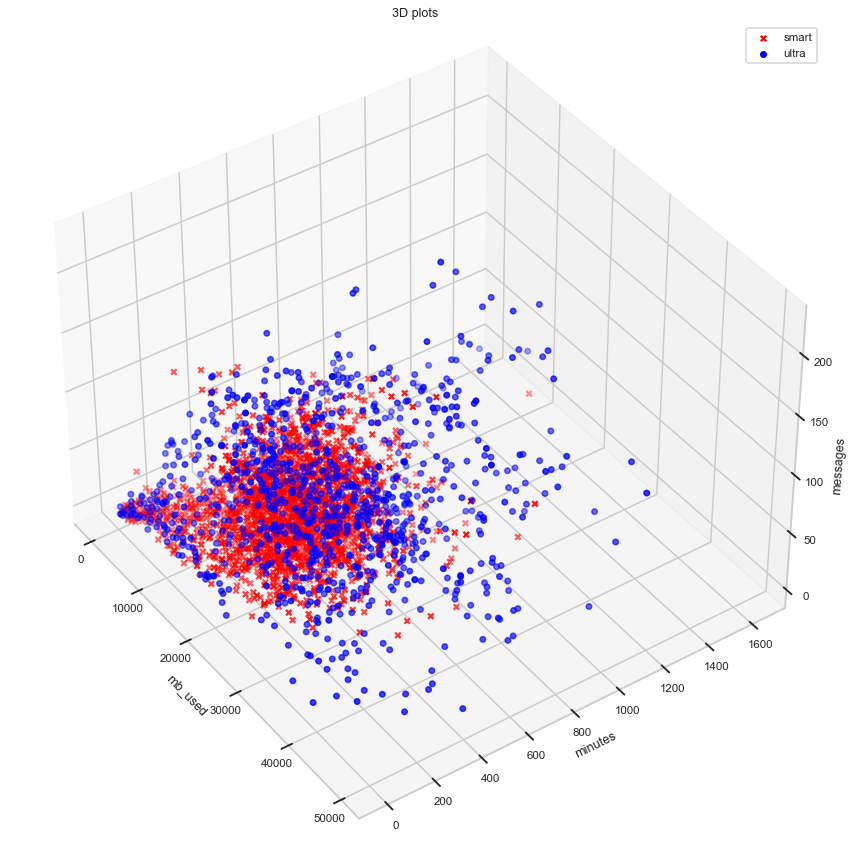

In [85]:
# создадим 3d оси
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(projection='3d')
# название графика
ax.set_title('3D plots')

ax.set_xlabel('mb_used')
ax.set_ylabel('minutes')
ax.set_zlabel('messages')
# угол обзора графика
ax.view_init(elev=40., azim=-35)

x_0 = df.mb_used[df['is_ultra'] == 0]
y_0 = df.minutes[df['is_ultra'] == 0]
z_0 = df.messages[df['is_ultra'] == 0]
x_1 = df.mb_used[df['is_ultra'] == 1]
y_1 = df.minutes[df['is_ultra'] == 1]
z_1 = df.messages[df['is_ultra'] == 1]

smart = ax.scatter3D(x_0,y_0,z_0, s=30, depthshade=True, marker='x', color='red', label='smart')
ultra = ax.scatter3D(x_1,y_1,z_1, s=30, depthshade=True, marker='o', color='blue', label='ultra')

ax.legend([smart, ultra],['smart', 'ultra'])

## Разбейте данные на выборки
Произведем разбивку данных в пропорциях:
- обучающие - 3 части
- валидационные - 1 часть
- тестовые - 1 часть

In [86]:
features = df.drop(['is_ultra'], axis=1)
target = df['is_ultra']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=12345)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25, random_state=12345)

print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)
print(X_test.shape)
print(y_test.shape)

(1928, 3)
(1928,)
(643, 3)
(643,)
(643, 3)
(643,)


In [87]:
# выполним стандартизацию данных
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
# вычислим параметры μ (эмпирическое среднее) и σ (стандартное отклонение) для каждой размерности признаков из тренировочных данных
sc.fit(X_train)
# стандартизируем данные, используя для этого расчетные параметры μ и σ.
X_train_std = sc.transform(X_train)
X_valid_std = sc.transform(X_valid)
X_test_std = sc.transform(X_test)
X_train_std

array([[-1.07348849, -0.11779249,  0.00460826],
       [-0.62814531,  1.04865142,  0.58184597],
       [-0.63177147, -0.63319794,  0.66758383],
       ...,
       [ 0.60445432, -1.01297037, -0.7870153 ],
       [-0.13064443,  0.66887899,  1.04241664],
       [ 0.66690019, -1.04009698, -0.11421852]])

## Исследуйте модели
### Логистическая регрессия

In [43]:
model_logr = LogisticRegression(C=1.0, random_state=12345)
model_logr.fit(X_train_std, y_train)
# выполним прогноз на валидационных данных
y_pred = model_logr.predict(X_valid_std)
# оценим среднюю квадратичную ошибку модели
mse_logr = mean_squared_error(y_valid, y_pred)
# оценим точность
acc_logr = accuracy_score(y_valid, y_pred)
print('Число ошибочно классифицированных образцов: %d' % (y_valid != y_pred).sum())

Число ошибочно классифицированных образцов: 176


### Логистическая регрессия в версии со стохастическим градиентным спуском

In [44]:
model_logr_sgd = SGDClassifier(loss='log')
model_logr_sgd.fit(X_train_std, y_train)
# выполним прогноз на валидационных данных
y_pred_logr_sgd = model_logr_sgd.predict(X_valid_std)
# оценим среднюю квадратичную ошибку модели
mse_logr_sgd = mean_squared_error(y_valid, y_pred_logr_sgd)
# оценим точность
acc_logr_sgd = accuracy_score(y_valid, y_pred_logr_sgd)
print('Число ошибочно классифицированных образцов: %d' % (y_valid != y_pred_logr_sgd).sum())

Число ошибочно классифицированных образцов: 177


### Перцептрон

In [45]:
model_ppn = Perceptron(max_iter=40, eta0=0.1, random_state=12345)
model_ppn.fit(X_train_std, y_train)

# выполним прогноз на валидационных данных
y_pred = model_ppn.predict(X_valid_std)
# оценим среднюю квадратичную ошибку модели
mse_ppn = mean_squared_error(y_valid, y_pred)
# оценим точность
acc_ppn = accuracy_score(y_valid, y_pred)
print('Число ошибочно классифицированных образцов: %d' % (y_valid != y_pred).sum())

Число ошибочно классифицированных образцов: 208


### Перцептрон в версии со стохастическим градиентным спуском

In [46]:
model_ppn_sgd = SGDClassifier(loss='perceptron')
model_ppn_sgd.fit(X_train_std, y_train)
# выполним прогноз на валидационных данных
y_pred_ppn_sgd = model_ppn_sgd.predict(X_valid_std)
# оценим среднюю квадратичную ошибку модели
mse_ppn_sgd = mean_squared_error(y_valid, y_pred_ppn_sgd)
# оценим точность
acc_ppn_sgd = accuracy_score(y_valid, y_pred_ppn_sgd)
print('Число ошибочно классифицированных образцов: %d' % (y_valid != y_pred_ppn_sgd).sum())

Число ошибочно классифицированных образцов: 247


### Дерево решений

In [47]:
model_dtc = DecisionTreeClassifier(random_state=12345)
model_dtc.fit(X_train_std, y_train)

# выполним прогноз на валидационных данных
y_pred = model_dtc.predict(X_valid_std)
# оценим среднюю квадратичную ошибку модели
mse_dtc = mean_squared_error(y_valid, y_pred)
# оценим точность
acc_dtc = accuracy_score(y_valid, y_pred)
print('Число ошибочно классифицированных образцов: %d' % (y_valid != y_pred).sum())

Число ошибочно классифицированных образцов: 192


### Случайный лес

In [70]:
model_rfc = RandomForestClassifier(n_estimators=100, random_state=12345)
model_rfc.fit(X_train_std, y_train)

# выполним прогноз на валидационных данных
y_pred = model_rfc.predict(X_valid_std)
# оценим среднюю квадратичную ошибку модели
mse_rfc = mean_squared_error(y_valid, y_pred)
# оценим точность
acc_rfc = accuracy_score(y_valid, y_pred)
print('Число ошибочно классифицированных образцов: %d' % (y_valid != y_pred).sum())

Число ошибочно классифицированных образцов: 138


### Какая модель самая лучшая ?

In [50]:
results = pd.DataFrame({
    'model': ['Logistic Regression', 'Logistic Regression SGD',
              'Random Forest', 'Perceptron', 'Perceptron SGD',
              'Decision Tree'],
    'mean_squared_error': [mse_logr, mse_logr_sgd, mse_rfc, mse_ppn, mse_ppn_sgd, mse_dtc],
    'accuracy_score': [acc_logr, acc_logr_sgd, acc_rfc, acc_ppn, acc_ppn_sgd, acc_dtc]})
result_df = results.sort_values(by='mean_squared_error', ascending=False)
result_df = results.sort_values(by='accuracy_score', ascending=False)
display(result_df)

,model,mean_squared_error,accuracy_score
2,Random Forest,0.214619,0.785381
0,Logistic Regression,0.273717,0.726283
1,Logistic Regression SGD,0.275272,0.724728
5,Decision Tree,0.298600,0.701400
3,Perceptron,0.323484,0.676516
4,Perceptron SGD,0.384137,0.615863


**Явный фаворит - модель Random Forest**
Критерий задачи выполнен, accuracy_score Random Forest > 0.75.
Попробуем еще что-нибудь выжать из этой модели.

Если нам интересно узнать о том, какие признаки являются самыми важными для нашей модели "Случайный лес" в деле предсказания тарифа, мы можем визуализировать показатели важности признаков, обратившись к атрибуту feature_importances_:

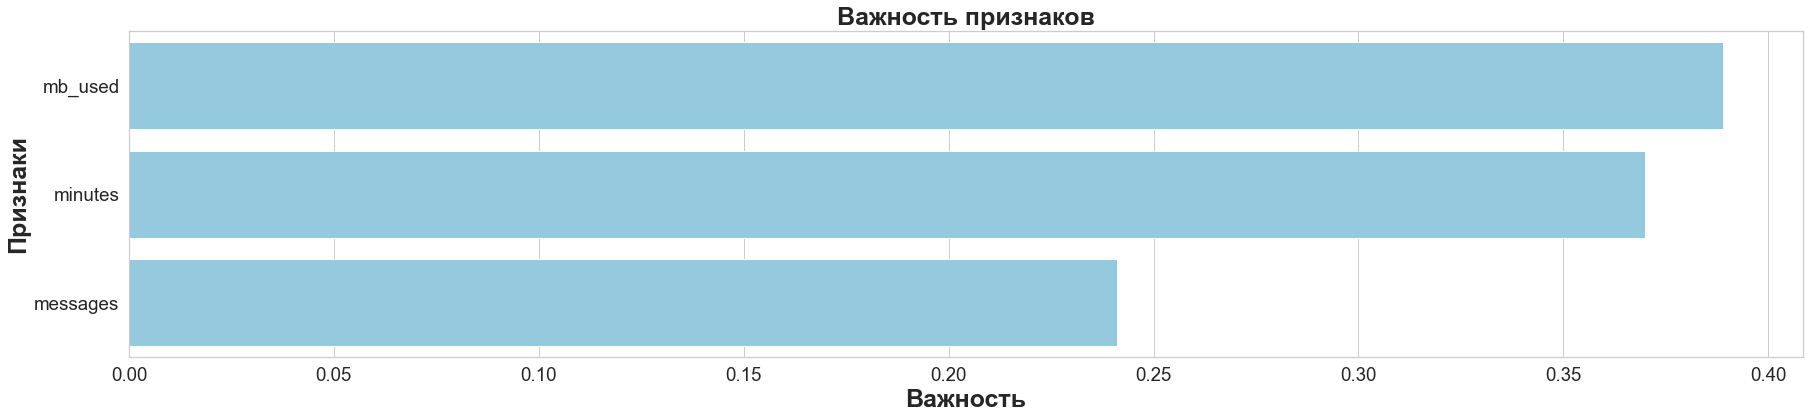

In [51]:
importances = pd.DataFrame({'признаки':features.columns,'важность':np.round(model_rfc.feature_importances_,3)})
importances = importances.sort_values('важность',ascending=False).set_index('признаки')

sns.set(font_scale = 5)
sns.set(style="whitegrid", color_codes=True, font_scale = 1.7)
fig, ax = plt.subplots()
fig.set_size_inches(30,6)
sns.barplot(x=importances['важность'], y=importances.index, data=importances, color='skyblue')
plt.xlabel('Важность', fontsize=25, weight = 'bold')
plt.ylabel('Признаки', fontsize=25, weight = 'bold')
plt.title('Важность признаков', fontsize=25, weight = 'bold')
plt.show()

### Настройка гиперпараметра
Сначала для черновой настройки используем алгоритм RandomizedSearchCV, который позволяет довольно грубо исследовать широкие диапазоны значений.

Задаем значения гиперпараметров через генератор списков, затем создаем словарь `param_dist`, содержащий, для каждого гиперпараметра, диапазон значений, которые нужно испытать. Далее, инициализируем объект rs с помощью функции `RandomizedSearchCV()`, передавая ей нашу модель Случайный лес `model_rfc`, `param_dist`, число итераций и число кросс-валидаций, которые нужно выполнить.

Гиперпараметр `verbose` позволяет управлять объёмом информации, который выводится моделью в ходе её работы (наподобие вывода сведений в процессе обучения модели). Гиперпараметр `n_jobs` позволяет указывать то, сколько процессорных ядер нужно использовать для обеспечения работы модели. Установка `n_jobs` в значение -1 приведёт к более быстрой работе модели, так как при этом будут использоваться все ядра процессора.

Мы будем заниматься подбором следующих гиперпараметров:

- `n_estimators` — число «деревьев» в «случайном лесу».
- `max_features` — число признаков для выбора расщепления.
- `max_depth` — максимальная глубина деревьев.
- `min_samples_split` — минимальное число объектов, необходимое для того, чтобы узел дерева мог бы расщепиться.
- `min_samples_leaf` — минимальное число объектов в листьях.
- `bootstrap` — использование для построения деревьев подвыборки с возвращением.

In [52]:
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
criterion = ['gini', 'entropy']
max_features = ['log2', 'sqrt']
max_depth = [int(x) for x in np.linspace(start = 1, stop = 15, num = 15)]
min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
min_samples_leaf = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
bootstrap = [True, False]
param_dist = {'n_estimators': n_estimators,
              'criterion': criterion,
              'max_features': max_features,
              'max_depth': max_depth,
              'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf,
              'bootstrap': bootstrap}
rs = RandomizedSearchCV(model_rfc,
                        param_dist,
                        n_iter = 100,
                        cv = 3,
                        verbose = 1,
                        n_jobs=-1,
                        random_state=0)
rs.fit(X_train_std, y_train)
rs.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


{'n_estimators': 700,
 'min_samples_split': 44,
 'min_samples_leaf': 7,
 'max_features': 'log2',
 'max_depth': 11,
 'criterion': 'gini',
 'bootstrap': False}

При значениях параметров `n_iter` = 100 и `cv` = 3, мы создали 300 моделей, случайно выбирая комбинации представленных выше гиперпараметров. Мы можем обратиться к атрибуту `best_params_` для получения сведений о наборе параметров, позволяющем создать самую лучшую модель. Но на данной стадии это может не дать нам наиболее интересных данных о диапазонах параметров. Для того чтобы выяснить то, в каком диапазоне значений стоит продолжать поиск, создадим датафрейм, содержащий результаты работы алгоритма `RandomizedSearchCV`.

In [53]:
rs_df = pd.DataFrame(rs.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
rs_df = rs_df.drop([
    'mean_fit_time',
    'std_fit_time',
    'mean_score_time',
    'std_score_time',
    'params',
    'split0_test_score',
    'split1_test_score',
    'split2_test_score',
    'std_test_score'],
    axis=1)
# Результаты работы алгоритма RandomizedSearchCV
rs_df.head()

,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_criterion,param_bootstrap,mean_test_score,rank_test_score
0,700,44,7,log2,11,gini,False,0.820544,1
1,700,12,2,sqrt,13,entropy,True,0.819508,2
2,400,44,7,sqrt,12,entropy,False,0.819508,3
3,300,7,12,log2,13,gini,False,0.818472,4
4,700,23,7,log2,15,entropy,True,0.818471,5


Теперь создадим столбчатые графики, на которых, по оси Х, расположены значения гиперпараметров, а по оси Y — средние значения, показываемые моделями. Это позволит понять то, какие значения гиперпараметров, в среднем, лучше всего себя показывают.

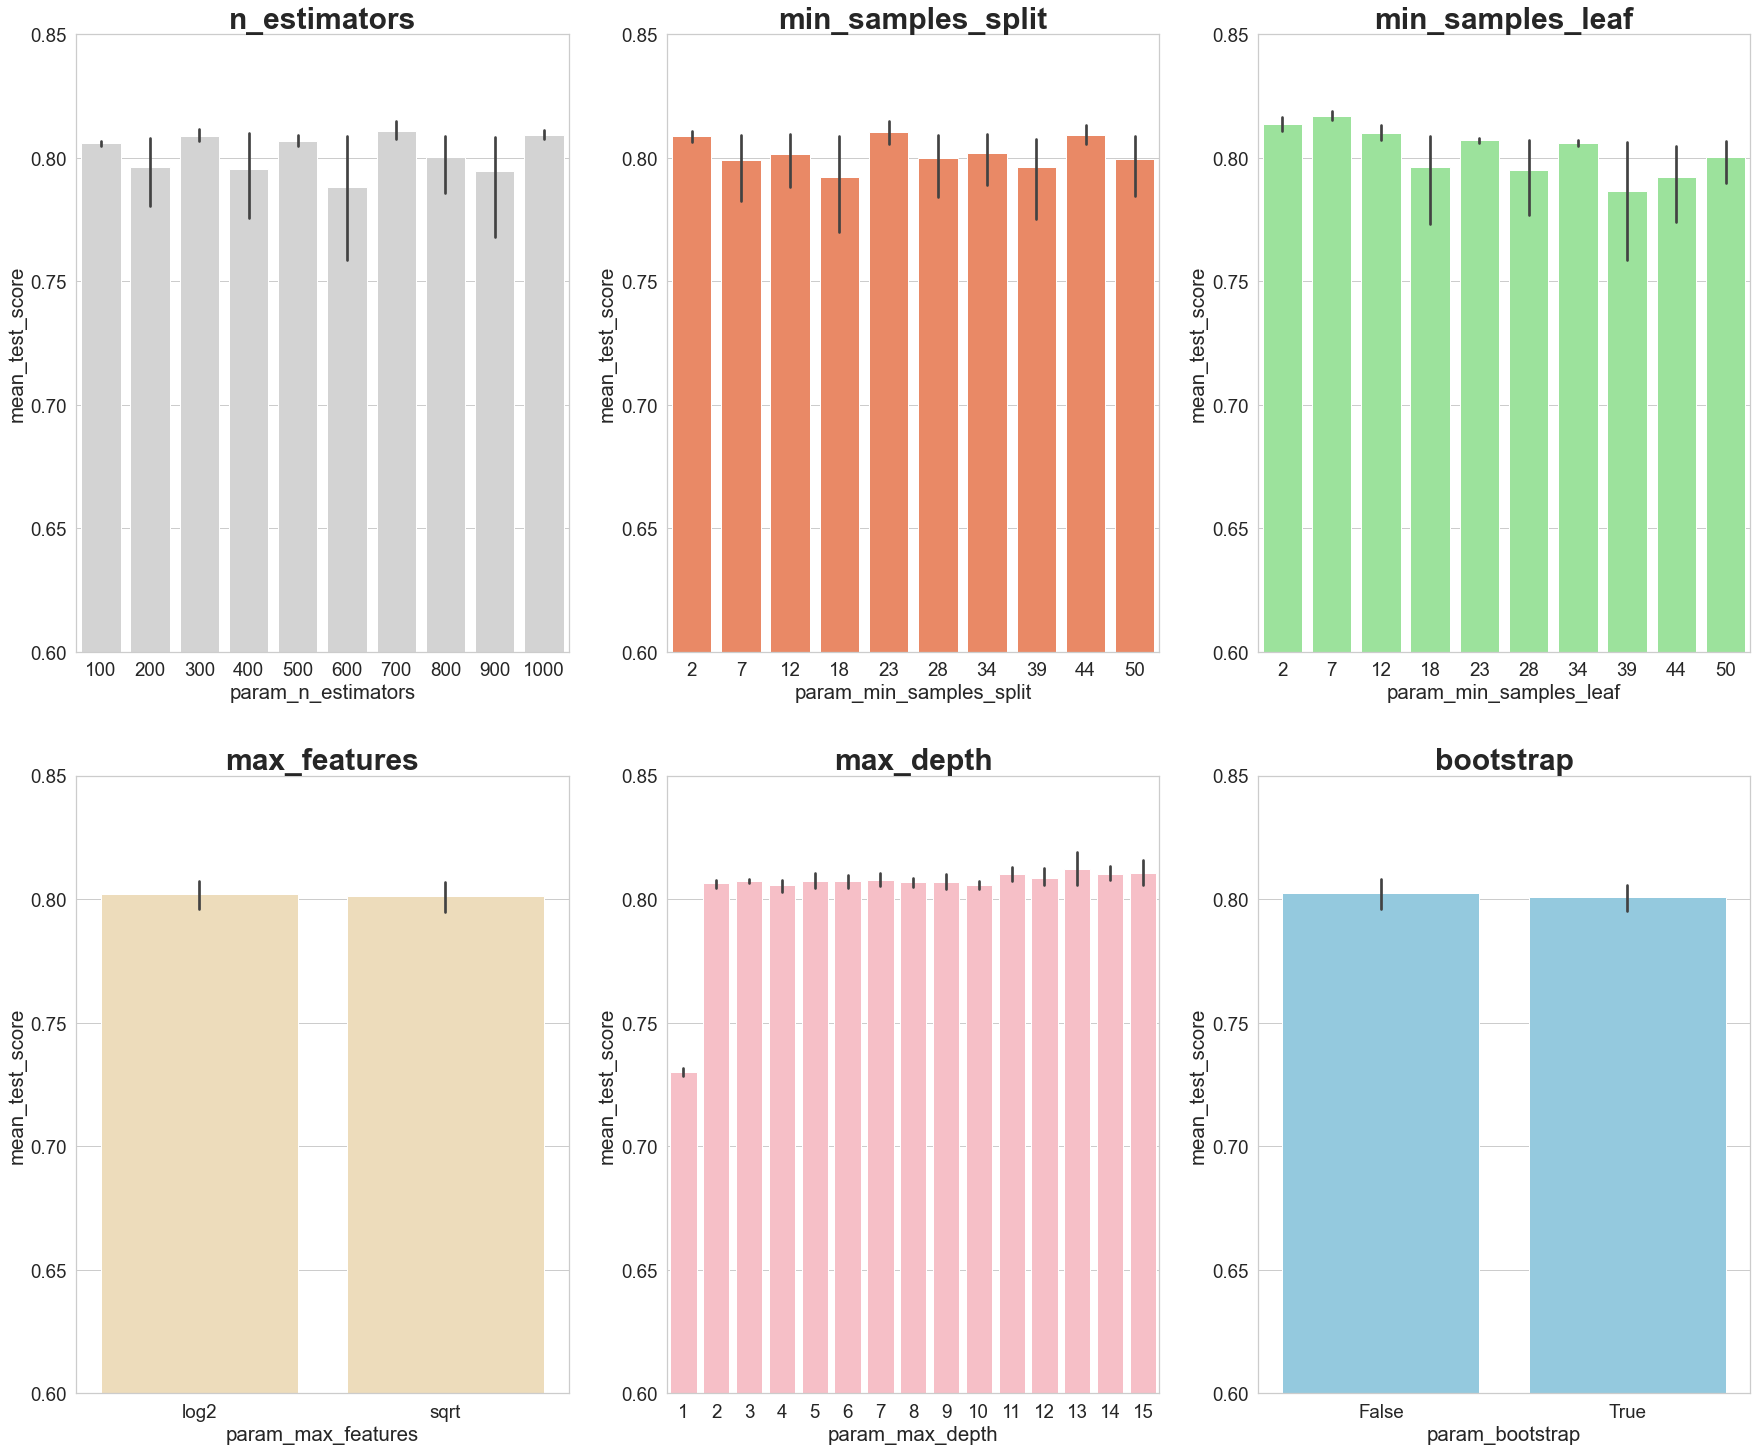

In [54]:
# Анализ значений гиперпараметров
fig, axs = plt.subplots(ncols=3, nrows=2)
sns.set(style="whitegrid", color_codes=True, font_scale = 2)
fig.set_size_inches(30,25)
sns.barplot(x='param_n_estimators', y='mean_test_score', data=rs_df, ax=axs[0,0], color='lightgrey')
axs[0,0].set_ylim([.6,.85]),axs[0,0].set_title(label = 'n_estimators', size=30, weight='bold')
sns.barplot(x='param_min_samples_split', y='mean_test_score', data=rs_df, ax=axs[0,1], color='coral')
axs[0,1].set_ylim([.6,.85]),axs[0,1].set_title(label = 'min_samples_split', size=30, weight='bold')
sns.barplot(x='param_min_samples_leaf', y='mean_test_score', data=rs_df, ax=axs[0,2], color='lightgreen')
axs[0,2].set_ylim([.6,.85]),axs[0,2].set_title(label = 'min_samples_leaf', size=30, weight='bold')
sns.barplot(x='param_max_features', y='mean_test_score', data=rs_df, ax=axs[1,0], color='wheat')
axs[1,0].set_ylim([.6,.85]),axs[1,0].set_title(label = 'max_features', size=30, weight='bold')
sns.barplot(x='param_max_depth', y='mean_test_score', data=rs_df, ax=axs[1,1], color='lightpink')
axs[1,1].set_ylim([.6,.85]),axs[1,1].set_title(label = 'max_depth', size=30, weight='bold')
sns.barplot(x='param_bootstrap',y='mean_test_score', data=rs_df, ax=axs[1,2], color='skyblue')
axs[1,2].set_ylim([.6,.85])
axs[1,2].set_title(label = 'bootstrap', size=30, weight='bold')
plt.show()

Если проанализировать вышеприведённые графики, то можно заметить некоторые интересные вещи, говорящие о том, как, в среднем, каждое значение гиперпараметра влияет на модель.

- `n_estimators`: значения 300, 700, 1000, видимо, показывают наилучшие средние результаты.
- `min_samples_split`: исследуем несколько значений этого гиперпараметра: 2, 23, 44.
- `min_samples_leaf`: мы можем испытать значения между 2, 7, 12.
- `max_features`: вариант log2 даёт самый высокий средний результат.
- `max_depth`: значения 11, 12, 13, 14, 15 выглядят неплохо.
- `bootstrap`: значение `False` показывает наилучший средний результат.

In [55]:
n_estimators = [300,700,1000]
criterion = ['gini', 'entropy']
max_features = ['log2']
max_depth = [11,12,13,14,15]
min_samples_split = [2,23,44]
min_samples_leaf = [2,7,12]
bootstrap = [False]
param_grid = {'n_estimators': n_estimators,
              'criterion': criterion,
              'max_features': max_features,
              'max_depth': max_depth,
              'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf,
              'bootstrap': bootstrap}
gs = GridSearchCV(model_rfc, param_grid, cv = 3, verbose = 1, n_jobs=-1)
gs.fit(X_train_std, y_train)
gs.best_params_

Fitting 3 folds for each of 270 candidates, totalling 810 fits


{'bootstrap': False,
 'criterion': 'entropy',
 'max_depth': 12,
 'max_features': 'log2',
 'min_samples_leaf': 7,
 'min_samples_split': 23,
 'n_estimators': 300}

## Проверьте модель на тестовой выборке
### Тестирование базовой модели `Random Forest`

In [56]:
# Random Forest
y_pred = model_rfc.predict(X_test_std)
# оценим среднюю квадратичную ошибку модели на тестовых данных
mse_rfc = mean_squared_error(y_test, y_pred)
# оценим точность на тестовых данных
acc_rfc = accuracy_score(y_test, y_pred)
print('Средняя квадратичная ошибка:', mse_rfc)
print('Оценка точности:', acc_rfc)

Средняя квадратичная ошибка: 0.2192846034214619
Оценка точности: 0.7807153965785381


### Тестирование оптимизированной модели `RandomizedSearchCV`

In [57]:
# Random Forest
model_rfc_rs = RandomForestClassifier(criterion = "gini",
                                   max_depth = 11,
                                   min_samples_leaf = 7,
                                   min_samples_split = 44,
                                   n_estimators=700,
                                   max_features='log2',
                                   bootstrap=False)

model_rfc_rs.fit(X_train_std, y_train)
y_pred_rs = model_rfc_rs.predict(X_test_std)
# оценим среднюю квадратичную ошибку модели на тестовых данных
mse_rfc_rs = mean_squared_error(y_test, y_pred_rs)
# оценим точность на тестовых данных
acc_rfc_rs = accuracy_score(y_test, y_pred_rs)
print('Средняя квадратичная ошибка:', mse_rfc_rs)
print('Оценка точности:', acc_rfc_rs)

Средняя квадратичная ошибка: 0.20217729393468117
Оценка точности: 0.7978227060653188


### Тестирование оптимизированной модели `GridSearchCV`

In [58]:
# Random Forest
model_rfc_gs = RandomForestClassifier(criterion = "entropy",
                                   max_depth = 12,
                                   min_samples_leaf = 7,
                                   min_samples_split = 23,
                                   n_estimators=300,
                                   max_features='log2',
                                   bootstrap=False)

model_rfc_gs.fit(X_train_std, y_train)
y_pred_gs = model_rfc_gs.predict(X_test_std)
# оценим среднюю квадратичную ошибку модели на тестовых данных
mse_rfc_gs = mean_squared_error(y_test, y_pred_gs)
# оценим точность на тестовых данных
acc_rfc_gs = accuracy_score(y_test, y_pred_gs)
print('Средняя квадратичная ошибка:', mse_rfc_gs)
print('Оценка точности:', acc_rfc_gs)

Средняя квадратичная ошибка: 0.2052877138413686
Оценка точности: 0.7947122861586314


## (бонус) Проверьте модели на адекватность
### Матрица ошибок базовой модели Random Forest

In [59]:
error_matrix = pd.DataFrame(confusion_matrix(y_test, y_pred), index = ['actual 0', 'actual 1'], columns = ['predicted 0', 'predicted 1'])
display(error_matrix)

print(classification_report(y_test, y_pred))

,predicted 0,predicted 1
actual 0,400,47
actual 1,94,102


              precision    recall  f1-score   support

           0       0.81      0.89      0.85       447
           1       0.68      0.52      0.59       196

    accuracy                           0.78       643
   macro avg       0.75      0.71      0.72       643
weighted avg       0.77      0.78      0.77       643



### Матрица ошибок оптимизированной модели `RandomizedSearchCV`

In [60]:
error_matrix_rs = pd.DataFrame(confusion_matrix(y_test, y_pred_rs), index = ['actual 0', 'actual 1'], columns = ['predicted 0', 'predicted 1'])
display(error_matrix_rs)

print(classification_report(y_test, y_pred_rs))

,predicted 0,predicted 1
actual 0,409,38
actual 1,92,104


              precision    recall  f1-score   support

           0       0.82      0.91      0.86       447
           1       0.73      0.53      0.62       196

    accuracy                           0.80       643
   macro avg       0.77      0.72      0.74       643
weighted avg       0.79      0.80      0.79       643



### Матрица ошибок оптимизированной модели `GridSearchCV`

In [61]:
error_matrix_gs = pd.DataFrame(confusion_matrix(y_test, y_pred_gs), index = ['actual 0', 'actual 1'], columns = ['predicted 0', 'predicted 1'])
display(error_matrix_gs)

print(classification_report(y_test, y_pred_gs))

,predicted 0,predicted 1
actual 0,408,39
actual 1,93,103


              precision    recall  f1-score   support

           0       0.81      0.91      0.86       447
           1       0.73      0.53      0.61       196

    accuracy                           0.79       643
   macro avg       0.77      0.72      0.74       643
weighted avg       0.79      0.79      0.78       643



Предлагаю сравнить метрику нашей модели Random Forest, оптимизированной по алгоритму `GridSearchCV` с примитивной моделью классификатора Перцептрон, написанной "на коленках".

In [62]:
class Perceptron(object):
    """Классификатор на основе Perceptron.

    Параметры
    ------------
    eta : float
        Скорость обучения (от 0,0 до 1,0)
    n_iter : int
        Проходы по тренировочному набору данных.

    Атрибуты
    -----------
    w_ : 1-мерный массив
        Весовые коэффициенты после подгонки..
    errors_ : list
        Число случаев ошибочной классификации в каждой эпохе.

    """
    def __init__(self, eta=0.01, n_iter=10):
        self.eta = eta
        self.n_iter = n_iter

    def fit(self, X, y):
        """Выполнить подгонку модели под тренировочные данные

        Параметры
        ----------
        X : {массивоподобный}, форма = [n_samples, n_features]
            тренировочные векторы, где
            n_samples - число образцов и
            n_features - число признаков.
        y : массивоподобный, форма = [n_samples]
            Целевые значения.

        Метод возвращает
        -------
        self : object

        """
        # Функция zeros() возвращает новый массив указанной формы и типа, заполненный нулями.
        self.w_ = np.zeros(1 + X.shape[1])
        # список ошибочных распознаваний классов в каждой итерации для последующего анализа качества обучения
        self.errors_ = []

        for _ in range(self.n_iter):
            errors = 0
            # метод fit() в цикле просматривает отдельные образцы тренировочного набора и обновляет веса согласно правилу обучения перcептрона - если на каждой итерации классификация ошибочная, то веса корректируются.
            for xi, target in zip(X, y):
                update = self.eta * (target - self.predict(xi))
                self.w_[1:] += update * xi
                self.w_[0] += update
                errors += int(update != 0.0)
            self.errors_.append(errors)
        return self

    def net_input(self, X):
        """Рассчитать чистый вход
        с помощью функции dot() реализуем скалярное произведение векторов
        можно реализовать на python -  sum([i*j, for i, j in zip(a, b)]
        однако с библиотекой NumPy это эффективней за счет векторизации
        """
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def predict(self, X):
        """Метод возвращает метку класса после единичного скачка"""
        return np.where(self.net_input(X) >= 0.0, 1, 0)

# создаем объект перцептрона, темп обучения = 0.1, количество проходов на тренировочных данных = 10
primitive_ppn = Perceptron(eta=0.1, n_iter=10)
# обучаем модель
primitive_ppn.fit(X_train_std, y_train)
# выполним предсказание на тестовых данных
y_pred_primitive_ppn = primitive_ppn.predict(X_test_std)
# рассчитаем матрицу ошибок
error_matrix_ppn = pd.DataFrame(confusion_matrix(y_test, y_pred_primitive_ppn), index = ['actual 0', 'actual 1'], columns = ['predicted 0', 'predicted 1'])
display(error_matrix_ppn)
# выведим отчет по классификации
print(classification_report(y_test, y_pred_primitive_ppn))

,predicted 0,predicted 1
actual 0,447,0
actual 1,192,4


              precision    recall  f1-score   support

           0       0.70      1.00      0.82       447
           1       1.00      0.02      0.04       196

    accuracy                           0.70       643
   macro avg       0.85      0.51      0.43       643
weighted avg       0.79      0.70      0.58       643



## Общий вывод

В рамках исследования с целью построения модели для задачи бинарной классификации клиентов оператора "Мегалайн" по тарифным планам `SMART` и `ULTRA` выполнены следующие основные этапы:

- выбраны случайным образом для решения задачи четыре алгоритма классификации из библиотеки `skikit-learn`:
    1. `Logistic Regression`
    2. `Perceptron`
    3. `Decision Tree`
    4. `Random Forest`
- на основании выбранных алгоритмов были построены одноименные модели, обучены на тренировочных данных и проверены на валидационных данных. По рассчетным метрикам `MSE = 0.21` и `accuracy_score = 0.79` был определен фаворит - модель `Random Forest`.
- для улучшения выбранной модели были использованы два алгоритма оптмизации гиперпараметров:
    1. `RandomizedSearchCV` - для первичной оптимизации
    2. `GridSearchCV` - для дополнительной оптимизации по выбранным гипермараметрам первичной оптимизации
- на этапе тестирования было проверено три модели:
    1. базовая модель *Random Forest*: `MSE = 0.22`, `accuracy_score = 0.78`
    2. оптимизированная модель *Random Forest RandomizedSearchCV*: `MSE = 0.21`, `accuracy_score = 0.79`
    3. оптимизированная модель *Random Forest GridSearchCV*: `MSE = 0.20`, `accuracy_score = 0.80`
- на этапе проверки адекватности нашей модели `Random Forest`:
    1. были расчитаны матирцы ошибок для трех моделей `Random Forest`. Анализ матриц показал, что наша модель на уровне общей точности = 0.80 успешно предсказывает тарифы `SMART`, однако точность предсказания тарифов `ULTRA` оставляет желать лучшего.
    2. для трех моделей были выведены отчеты по классификации. Оценочная метрика `recall_score` подтверждает выявленный  выше нюанс в матрице ошибок.

  | *Модель*     | *Класс* | *Recall_score*|
|--------------|---------| --- |
  | model_rfc    | Smart   | 0.89|
  | ---------    | Ultra   | 0.52|
  | model_rfc_rs | Smart   | 0.91|
  | ---------    | Ultra   | 0.53|
  | model_rfc_gs | Smart   | 0.91|
  | ---------    | Ultra   | 0.53|

    3. Отталкиваясь от значений `accuracy_score` и `recall_score` выбрана наиболее оптимальная модель для классификации - Random Forest, оптимизированная по алгоритму `GridSearchCV`
    4. В конце бало проведено сравнение нашей выбранной модели с примитивной моделью классификации Перцептрон. Отчет по классификации примитивной модели Перцептрон показал её примитивность. Не углубляясь в интерпретацию других метрик отчета, в целом мы видим, что общая точность примитивной модели ниже нашей модели за счет еще более худшего результата в предсказании тарифа `ULTRA`

  | *Модель*     | *Accuracy_score* | *Класс*     | *Recall_score*|
|--------------|------------------|-------------| --- |
  | Perceptron   | 0.70 | Smart | 1.0 |
  | ---------    | ------- | Ultra | 0.02 |
  | Model_rfc_gs | 0.80 | Smart | 0.91 |
  | ---------    | ------- | Ultra | 0.53 |
